## T3 EBOD Gao, X., Yu, J., Zha, S., Fu, S., Xue, B., Ye, P., Huang, Z., & Zhang, G. (2022). An ensemble-based outlier detection method for clustered and local outliers with differential potential spread loss. Knowledge-Based Systems, 258, 110003. https://doi.org/10.1016/j.knosys.2022.110003

   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0
Silhouette Score: 0.036743206249025336
Davies-Bouldin Index: 14.26144144960354
S/DB Ratio: 0.0025764001917242987
Number of Outliers: 142
Percentage of Outliers: 9.99%
AUC Value: 0.47413515363859693


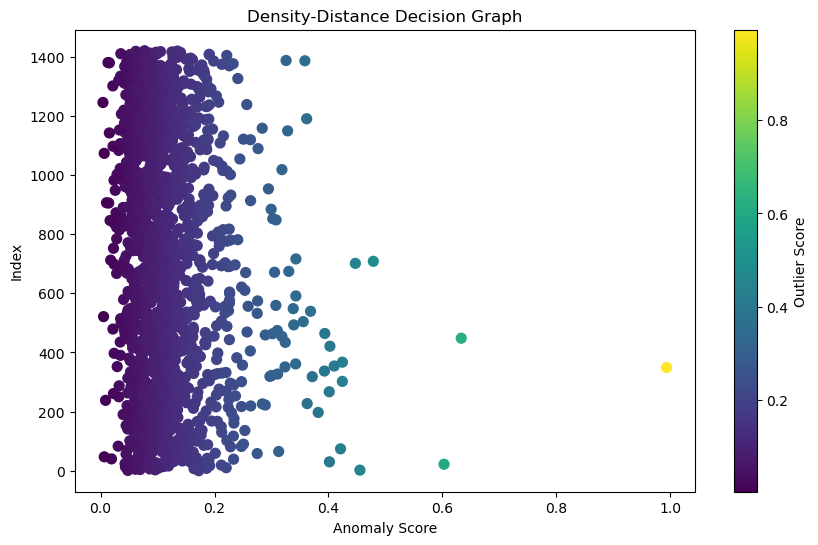

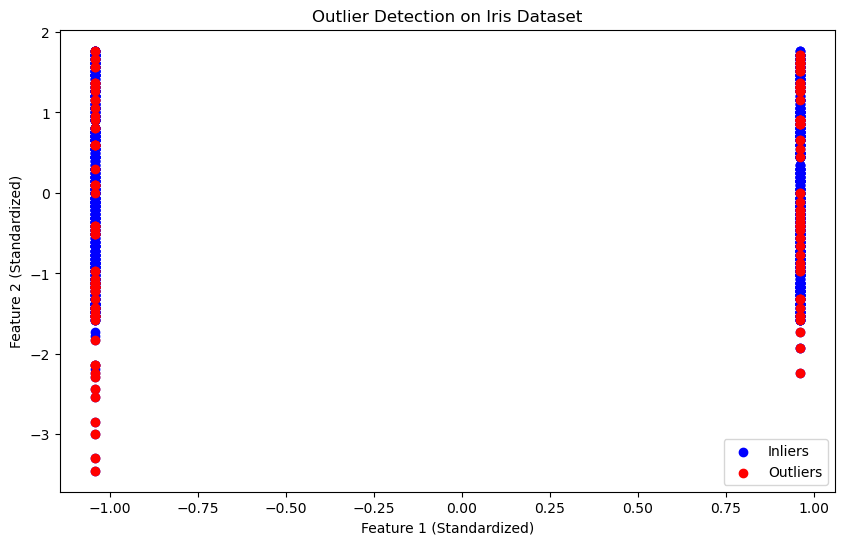

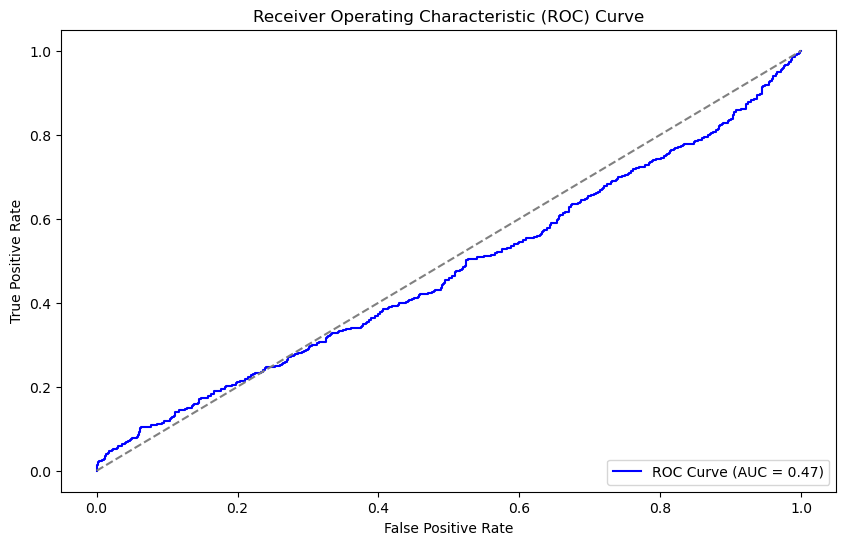

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# # Load and preprocess Iris dataset
# data = load_iris()
# X = data.data
# y_true = (data.target == 2).astype(int)  # Binary labels for ROC curve
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

file_path = r"D:\Research Related\30 Deep Robust Clustering with Mahalanobis Distance (DRCMD)\dataset\anemia.csv"
# Load the dataset into a pandas DataFrame
data = pd.read_csv(file_path)
# Display the first few rows of the dataset to understand its structure
print(data.head())
# Remove the last column
# Separate the features (X) and the target variable (y_true)
X = data.iloc[:, :-1]  # All columns except the last
y_true = data.iloc[:, -1]  # The last column

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
n_neighbors = 5  # Number of neighbors
subsampling_ratio = 0.8
n_iterations = 10

# Function to compute potential spread loss
def compute_psl(X, neighbors, radii):
    psl = []
    for i in range(len(X)):
        chain_length = len(neighbors[i])
        spread_distance = 0
        for j in range(1, chain_length):
            spread_distance += np.linalg.norm(X[neighbors[i][j]] - X[neighbors[i][j - 1]])
        isolation_radius_ratio = radii[i] / radii[neighbors[i][0]]
        psl.append(spread_distance * isolation_radius_ratio)
    return np.array(psl)

# Function to compute anomaly scores
def compute_anomaly_scores(X, n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    radii = distances[:, -1]  # Isolation radius
    neighbors = indices

    psl = compute_psl(X, neighbors, radii)

    # Normalize anomaly scores
    anomaly_scores = (psl - np.min(psl)) / (np.max(psl) - np.min(psl))
    return anomaly_scores

# Subsampling and anomaly detection
final_scores = np.zeros(len(X))
for _ in range(n_iterations):
    subsample_idx = np.random.choice(len(X), int(len(X) * subsampling_ratio), replace=False)
    subsample = X.iloc[subsample_idx]  # Use .iloc for positional indexing
    anomaly_scores = compute_anomaly_scores(subsample.values, n_neighbors)  # Ensure numpy array

    # Assign scores back to original data points
    for i, idx in enumerate(subsample_idx):
        final_scores[idx] += anomaly_scores[i]

# Normalize final scores
final_scores = final_scores / n_iterations

# Thresholding to identify outliers
threshold = np.percentile(final_scores, 90)
outliers = final_scores > threshold

# Metrics
outliers_count = np.sum(outliers)
outliers_percentage = outliers_count / len(X) * 100
silhouette = silhouette_score(X_scaled, outliers.astype(int))
davies_bouldin = davies_bouldin_score(X_scaled, outliers.astype(int))
s_db_ratio = silhouette / (davies_bouldin + 1e-5)  # Avoid division by zero

# ROC and AUC
fpr, tpr, _ = roc_curve(y_true, final_scores)
roc_auc = roc_auc_score(y_true, final_scores)

# Print Metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Number of Outliers:", outliers_count)
print("Percentage of Outliers:", f"{outliers_percentage:.2f}%")
print("AUC Value:", roc_auc)

# Visualization of Density-Distance Decision Graph
plt.figure(figsize=(10, 6))
plt.scatter(final_scores, np.arange(len(final_scores)), c=final_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Anomaly Score')
plt.ylabel('Index')
plt.show()

# Highlight Detected Outliers
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='Outliers')
plt.title('Outlier Detection on Iris Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# 17/12/2024

Silhouette Score: 0.033
Davies-Bouldin Index: 8.798
S/DB Ratio: 0.004
Adjusted Rand Index (ARI): -0.024
F1 Score: 0.397
Hubness Score: 3.898
Number of Outliers: 100
Percentage of Outliers: 10.00%
AUC Value: 0.44250848896434636


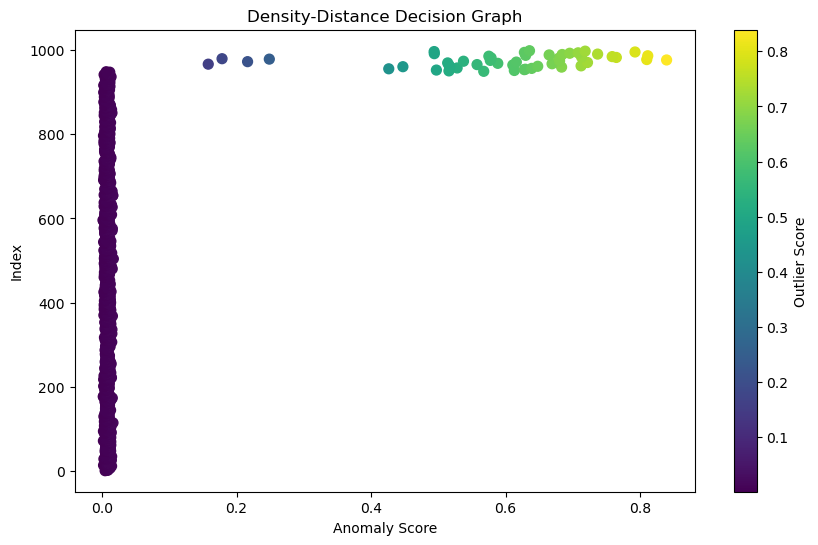

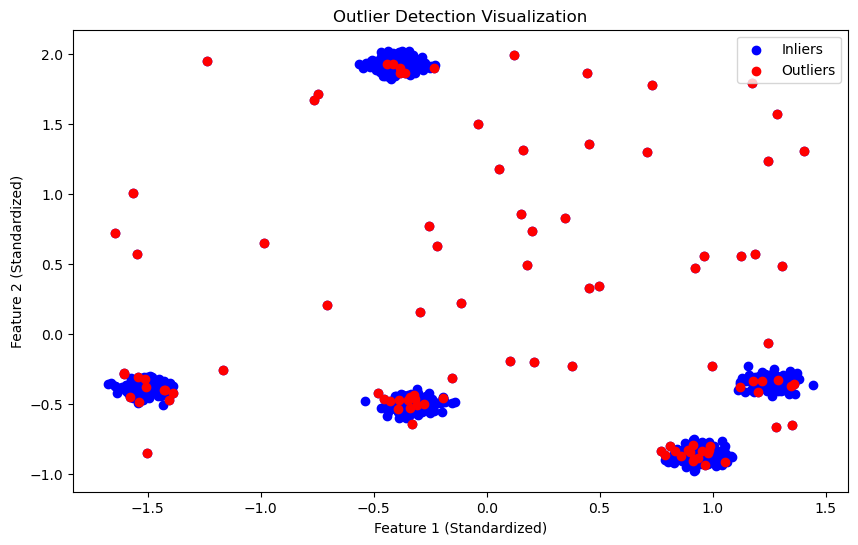

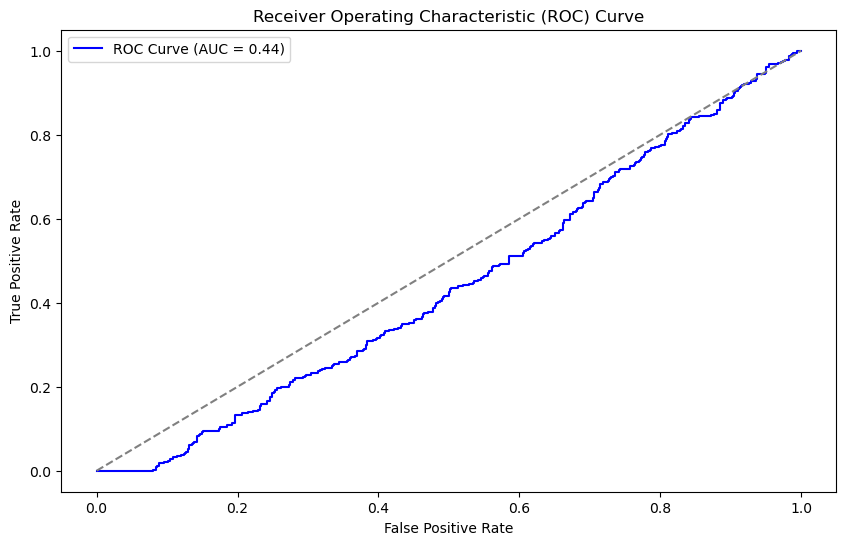

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve,
    adjusted_rand_score, f1_score
)
import matplotlib.pyplot as plt

# Load the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)

# Preprocess the data
X = data.iloc[:, :-1]  # Features
y_true = data.iloc[:, -1]  # Target variable (true labels)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
n_neighbors = 5  # Number of neighbors
subsampling_ratio = 0.8
n_iterations = 10

# Function to compute potential spread loss (PSL)
def compute_psl(X, neighbors, radii):
    psl = []
    for i in range(len(X)):
        chain_length = len(neighbors[i])
        spread_distance = 0
        for j in range(1, chain_length):
            spread_distance += np.linalg.norm(X[neighbors[i][j]] - X[neighbors[i][j - 1]])
        isolation_radius_ratio = radii[i] / radii[neighbors[i][0]]
        psl.append(spread_distance * isolation_radius_ratio)
    return np.array(psl)

# Function to compute anomaly scores
def compute_anomaly_scores(X, n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    radii = distances[:, -1]  # Isolation radius
    neighbors = indices

    psl = compute_psl(X, neighbors, radii)

    # Normalize anomaly scores
    anomaly_scores = (psl - np.min(psl)) / (np.max(psl) - np.min(psl))
    return anomaly_scores

# Subsampling and anomaly detection
final_scores = np.zeros(len(X))
X_array = X.values  # Convert X to a NumPy array for indexing consistency

for _ in range(n_iterations):
    subsample_idx = np.random.choice(len(X_array), int(len(X_array) * subsampling_ratio), replace=False)
    subsample = X_array[subsample_idx]  # Use NumPy indexing here
    anomaly_scores = compute_anomaly_scores(subsample, n_neighbors)

    # Assign scores back to original data points
    for i, idx in enumerate(subsample_idx):
        final_scores[idx] += anomaly_scores[i]

# Normalize final scores
final_scores = final_scores / n_iterations

# Thresholding to identify outliers
threshold = np.percentile(final_scores, 90)
outliers = final_scores > threshold

# Metrics
outliers_count = np.sum(outliers)
outliers_percentage = outliers_count / len(X) * 100
silhouette = silhouette_score(X_scaled, outliers.astype(int))
davies_bouldin = davies_bouldin_score(X_scaled, outliers.astype(int))
s_db_ratio = silhouette / (davies_bouldin + 1e-5)

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_true, outliers.astype(int))

# F1 Score
f1 = f1_score(y_true, outliers.astype(int), average="macro")

# Hubness Score
def hubness_score(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.std(hubness)

hub_score = hubness_score(X_scaled, n_neighbors)

# ROC and AUC
fpr, tpr, _ = roc_curve(y_true, final_scores)
roc_auc = roc_auc_score(y_true, final_scores)

# # Print Metrics
print("Silhouette Score:", np.round(silhouette, 3))
print("Davies-Bouldin Index:", np.round(davies_bouldin, 3))
print("S/DB Ratio:", np.round(s_db_ratio, 3))
print("Adjusted Rand Index (ARI):", np.round(ari, 3))
print("F1 Score:", np.round(f1, 3))
print("Hubness Score:", np.round(hub_score, 3))
print("Number of Outliers:", np.round(outliers_count, 3))
print("Percentage of Outliers:", f"{outliers_percentage:.2f}%")
print("AUC Value:", roc_auc)

# # Hubness Score
# def hubness_score(X, k=5):
#     nbrs = NearestNeighbors(n_neighbors=k).fit(X)
#     indices = nbrs.kneighbors(X, return_distance=False)
#     hubness = np.bincount(indices.flatten(), minlength=len(X))
#     return np.mean(hubness), np.std(hubness)

# # Calculate Hubness Score
# hubness_mean, hubness_std = hubness_score(X_scaled, k=5)

# # Print Metrics
# # print("Silhouette Score:", np.round(silhouette, 3))
# # print("Davies-Bouldin Index:", np.round(davies_bouldin, 3))
# # print("S/DB Ratio:", np.round(s_db_ratio, 3))
# # print("Adjusted Rand Index (ARI):", np.round(ari, 3))
# # print("F1-Score:", np.round(f1, 3))
# # print("Hubness Score (Mean):", np.round(hubness_mean, 3))
# # print("Hubness Score (Std Dev):", np.round(hubness_std, 3))
# # print("AUC Value:", np.round(roc_auc, 3))


# # Results
# print("Silhouette Score:", np.round(silhouette, 3))
# print("Davies-Bouldin Index:", np.round(davies_bouldin, 3))
# print("S/DB Ratio:", np.round(s_db_ratio, 3))
# print("Adjusted Rand Index (ARI):", np.round(ari, 3))
# print("F1-Score:", np.round(f1, 3))
# print("Hubness Score (Mean):", np.round(hubness_mean, 3))
# print("Hubness Score (Std Dev):", np.round(hubness_std, 3))
# print("AUC Value:", np.round(roc_auc, 3))
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(final_scores, np.arange(len(final_scores)), c=final_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Anomaly Score')
plt.ylabel('Index')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='Outliers')
plt.title('Outlier Detection Visualization')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
